# Ploteos 2
Ploteo los datos pre-procesados de las mediciones

In [4]:
from scripts.sa_data import SAData, load_sa_data

In [5]:
directa_medida_27 = load_sa_data('./mediciones/directa_2.7GHz.DAT')
directa_medida_29 = load_sa_data('./mediciones/directa_2.9GHz.DAT')
directa_medida_31 = load_sa_data('./mediciones/directa_3.1GHz.DAT')
cruzada_medida_27 = load_sa_data('./mediciones/cruzada_2.7GHz.DAT')
cruzada_medida_29 = load_sa_data('./mediciones/cruzada_2.9GHz.DAT')
cruzada_medida_31 = load_sa_data('./mediciones/cruzada_3.1GHz.DAT')

directa_simulada_27 = load_sa_data('./simulaciones/directa_2.7GHz.DAT')
directa_simulada_29 = load_sa_data('./simulaciones/directa_2.9GHz.DAT')
directa_simulada_31 = load_sa_data('./simulaciones/directa_3.1GHz.DAT')
cruzada_simulada_27 = load_sa_data('./simulaciones/cruzada_2.7GHz.DAT')
cruzada_simulada_29 = load_sa_data('./simulaciones/cruzada_2.9GHz.DAT')
cruzada_simulada_31 = load_sa_data('./simulaciones/cruzada_3.1GHz.DAT')

# Ploteos superpuestos medidas

Ploteo superpuesto de mediciónes reales

In [6]:
directas_medidas_db = {'deg': directa_medida_27.convert_to_degree(min_deg=-180, max_deg=180), '2.7GHz': directa_medida_27.convert_to_dBm(), '2.9GHz': directa_medida_29.convert_to_dBm(), '3.1GHz': directa_medida_31.convert_to_dBm()}

In [7]:
cruzadas_medidas_db = {'deg': cruzada_medida_27.convert_to_degree(min_deg=-180, max_deg=180), '2.7GHz': cruzada_medida_27.convert_to_dBm(), '2.9GHz': cruzada_medida_29.convert_to_dBm(), '3.1GHz': cruzada_medida_31.convert_to_dBm()}

Por el recorte los ejes quedaron de distinta longitud. Normalizo promediando datos en el medio cuando no hay

In [8]:
# Normalización de ejes X para igualar dimensiones
import numpy as np
from scipy.interpolate import interp1d

def normalizar_ejes(datos_dict):
    """
    Normaliza todos los arrays al mismo tamaño usando interpolación lineal

    Parameters:
    -----------
    datos_dict : dict
        Diccionario con datos a normalizar

    Returns:
    --------
    dict
        Diccionario con arrays normalizados al mismo tamaño
    """
    # Encontrar el tamaño máximo entre todos los arrays
    tamanos = [len(datos_dict[key]) for key in datos_dict.keys() if key != 'deg']
    max_tamano = max(tamanos)

    # Crear nuevo diccionario normalizado
    datos_norm = {}

    # Para cada frecuencia, interpolar al tamaño máximo
    for key in datos_dict.keys():
        if key == 'deg':
            # Para el eje de grados, crear nuevo rango del tamaño máximo
            datos_norm[key] = np.linspace(np.min(datos_dict[key]), np.max(datos_dict[key]), max_tamano)
        else:
            # Para los datos de potencia, interpolar linealmente
            x_original = np.linspace(0, 1, len(datos_dict[key]))
            x_nuevo = np.linspace(0, 1, max_tamano)

            interpolador = interp1d(x_original, datos_dict[key], kind='linear', fill_value='extrapolate')
            datos_norm[key] = interpolador(x_nuevo)

    return datos_norm

# Aplicar normalización a ambos diccionarios
directas_medidas_db_norm = normalizar_ejes(directas_medidas_db)
cruzadas_medidas_db_norm = normalizar_ejes(cruzadas_medidas_db)

print(f"Tamaños originales directas: {[len(directas_medidas_db[key]) for key in directas_medidas_db.keys() if key != 'deg']}")
print(f"Tamaños originales cruzadas: {[len(cruzadas_medidas_db[key]) for key in cruzadas_medidas_db.keys() if key != 'deg']}")
print(f"Tamaño normalizado: {len(directas_medidas_db_norm['2.7GHz'])}")

Tamaños originales directas: [1891, 2001, 1905]
Tamaños originales cruzadas: [1890, 2001, 1947]
Tamaño normalizado: 2001


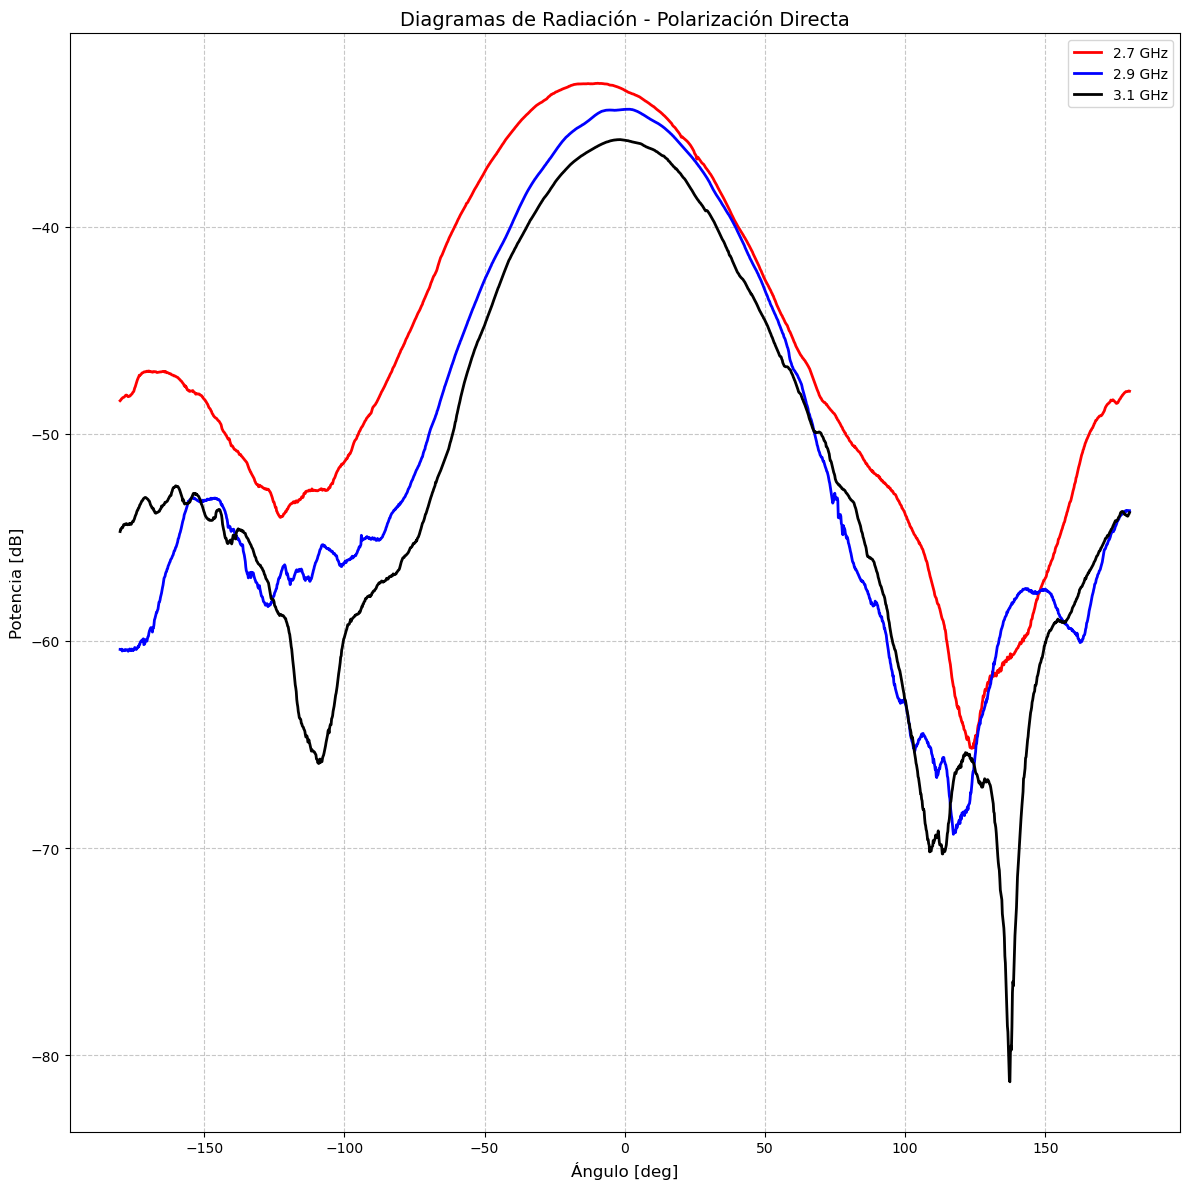

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Ploteo 1: Polarizaciones directas con las tres frecuencias superpuestas
plt.figure(figsize=(12, 12))
plt.plot(directas_medidas_db_norm['deg'], directas_medidas_db_norm['2.7GHz'], 'r-', linewidth=2, label='2.7 GHz')
plt.plot(directas_medidas_db_norm['deg'], directas_medidas_db_norm['2.9GHz'], 'b-', linewidth=2, label='2.9 GHz')
plt.plot(directas_medidas_db_norm['deg'], directas_medidas_db_norm['3.1GHz'], 'k-', linewidth=2, label='3.1 GHz')

plt.title('Diagramas de Radiación - Polarización Directa', fontsize=14)
plt.xlabel('Ángulo [deg]', fontsize=12)
plt.ylabel('Potencia [dB]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('./ploteos/directa_medida.png',dpi=300)
plt.show()

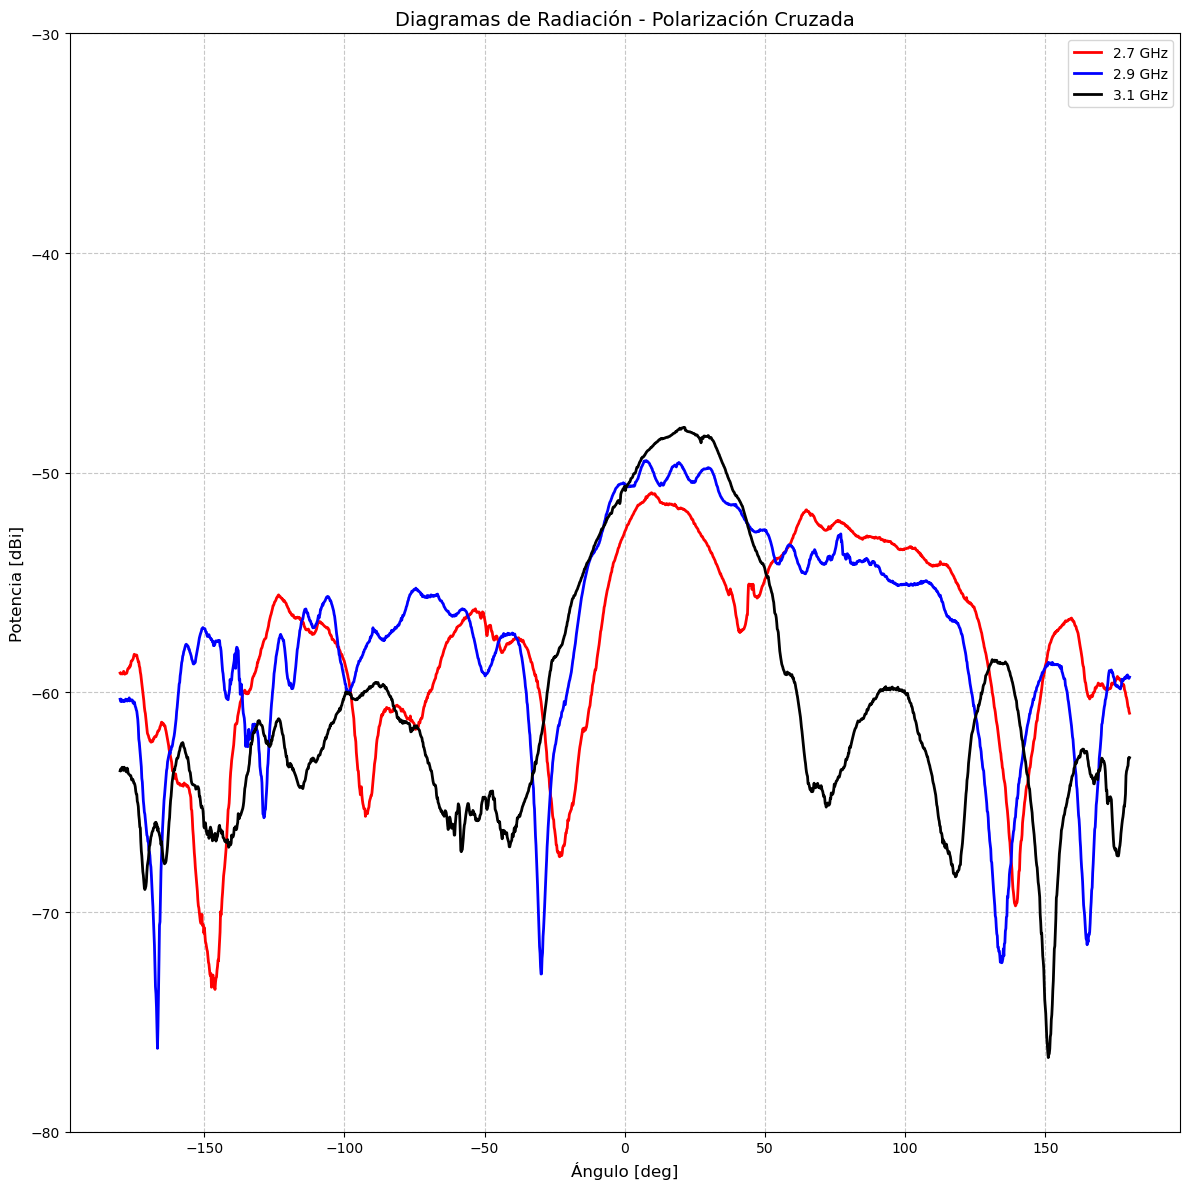

In [11]:
# Ploteo 2: Polarizaciones cruzadas con las tres frecuencias superpuestas
plt.figure(figsize=(12, 12))
plt.plot(cruzadas_medidas_db_norm['deg'], cruzadas_medidas_db_norm['2.7GHz'], 'r-', linewidth=2, label='2.7 GHz')
plt.plot(cruzadas_medidas_db_norm['deg'], cruzadas_medidas_db_norm['2.9GHz'], 'b-', linewidth=2, label='2.9 GHz')
plt.plot(cruzadas_medidas_db_norm['deg'], cruzadas_medidas_db_norm['3.1GHz'], 'k-', linewidth=2, label='3.1 GHz')

plt.title('Diagramas de Radiación - Polarización Cruzada', fontsize=14)
plt.ylim(-80, -30)
plt.xlabel('Ángulo [deg]', fontsize=12)
plt.ylabel('Potencia [dBi]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('./ploteos/cruzada_medida.png',dpi=300)
plt.show()

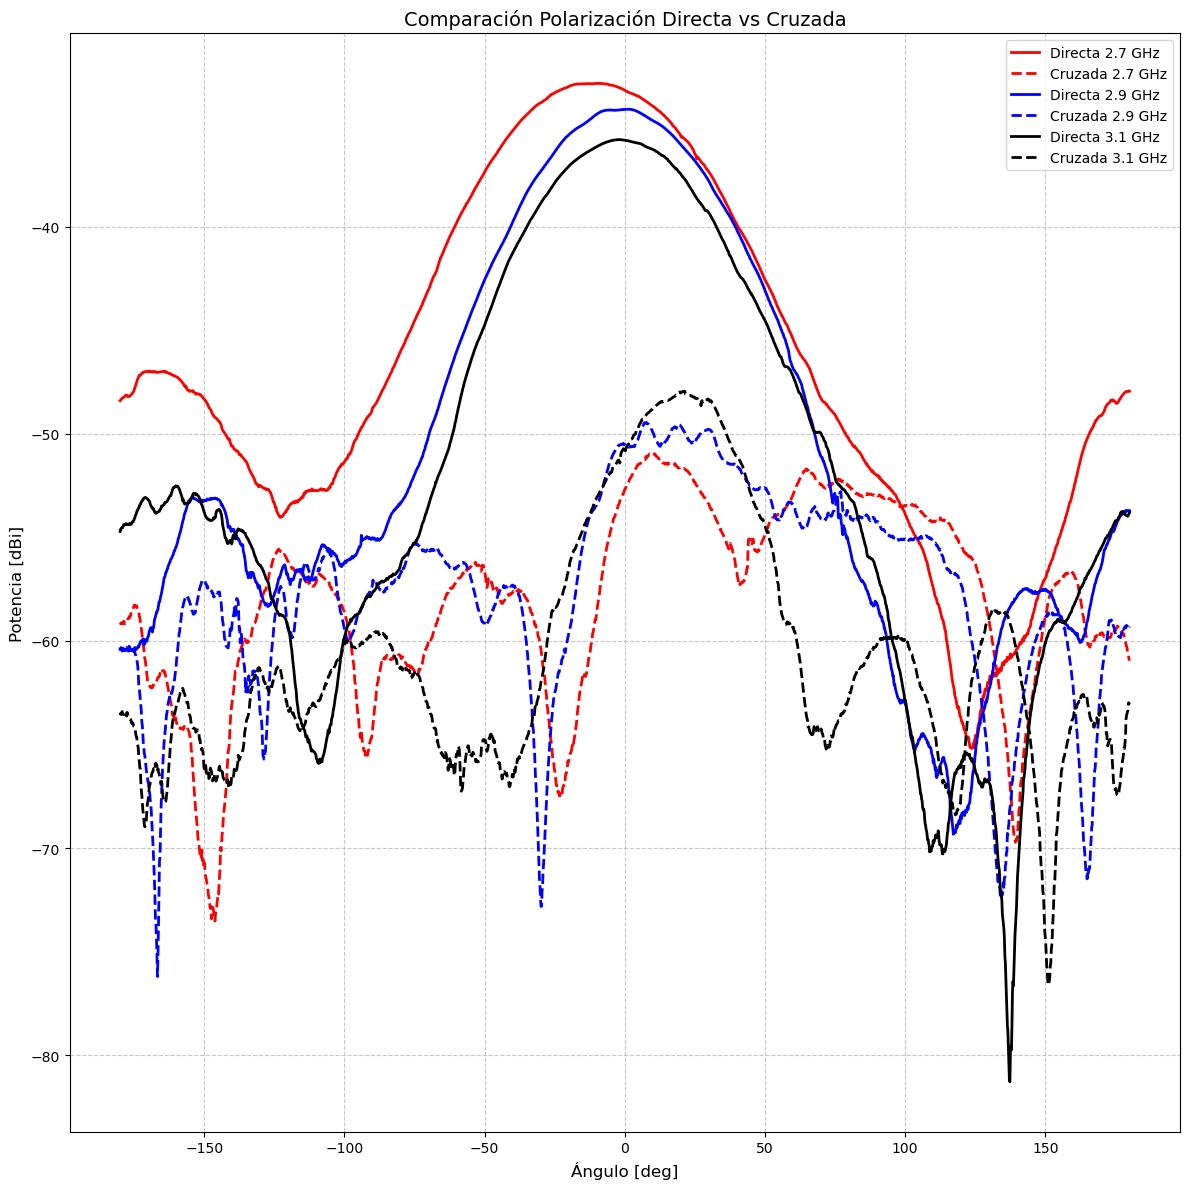

In [12]:

# Ploteo 3: Comparación directas vs cruzadas para las tres frecuencias
plt.figure(figsize=(12, 12))

# 2.7 GHz
plt.plot(directas_medidas_db_norm['deg'], directas_medidas_db_norm['2.7GHz'], 'r-', linewidth=2, label='Directa 2.7 GHz')
plt.plot(cruzadas_medidas_db_norm['deg'], cruzadas_medidas_db_norm['2.7GHz'], 'r--', linewidth=2, label='Cruzada 2.7 GHz')

# 2.9 GHz
plt.plot(directas_medidas_db_norm['deg'], directas_medidas_db_norm['2.9GHz'], 'b-', linewidth=2, label='Directa 2.9 GHz')
plt.plot(cruzadas_medidas_db_norm['deg'], cruzadas_medidas_db_norm['2.9GHz'], 'b--', linewidth=2, label='Cruzada 2.9 GHz')

# 3.1 GHz
plt.plot(directas_medidas_db_norm['deg'], directas_medidas_db_norm['3.1GHz'], 'k-', linewidth=2, label='Directa 3.1 GHz')
plt.plot(cruzadas_medidas_db_norm['deg'], cruzadas_medidas_db_norm['3.1GHz'], 'k--', linewidth=2, label='Cruzada 3.1 GHz')

plt.title('Comparación Polarización Directa vs Cruzada', fontsize=14)
plt.xlabel('Ángulo [deg]', fontsize=12)
plt.ylabel('Potencia [dBi]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('./ploteos/completo_medida.png',dpi=300)
plt.show()

# Ploteos superpuestos simuladas

In [13]:
 # Normalización de ejes X para igualar dimensiones con función previamente definida

In [14]:
 directas_simuladas_db = {'deg': directa_simulada_27.convert_to_degree(min_deg=-180, max_deg=180), '2.7GHz': directa_simulada_27.convert_to_dBm(), '2.9GHz': directa_simulada_29.convert_to_dBm(), '3.1GHz': directa_simulada_31.convert_to_dBm()}
 cruzadas_simuladas_db = {'deg': cruzada_simulada_27.convert_to_degree(min_deg=-180, max_deg=180), '2.7GHz': cruzada_simulada_27.convert_to_dBm(), '2.9GHz': cruzada_simulada_29.convert_to_dBm(), '3.1GHz': cruzada_simulada_31.convert_to_dBm()}

 directas_simuladas_db_norm = normalizar_ejes(directas_simuladas_db)
 cruzadas_simuladas_db_norm = normalizar_ejes(cruzadas_simuladas_db)

 print(f"Tamaños originales directas: {[len(directas_simuladas_db[key]) for key in directas_simuladas_db.keys() if key != 'deg']}")
 print(f"Tamaños originales cruzadas: {[len(cruzadas_simuladas_db[key]) for key in cruzadas_simuladas_db.keys() if key != 'deg']}")
 print(f"Tamaño normalizado: {len(directas_simuladas_db_norm['2.7GHz'])}")

ValueError: Unit 'DBI;' not recognized for conversion to dBm

In [ ]:
 import matplotlib.pyplot as plt
 import numpy as np

 # Ploteo 1: Polarizaciones directas con las tres frecuencias superpuestas
 plt.figure(figsize=(12, 12))
 plt.plot(directas_simuladas_db_norm['deg'], directas_simuladas_db_norm['2.7GHz'], 'r-', linewidth=2, label='2.7 GHz')
 plt.plot(directas_simuladas_db_norm['deg'], directas_simuladas_db_norm['2.9GHz'], 'b-', linewidth=2, label='2.9 GHz')
 plt.plot(directas_simuladas_db_norm['deg'], directas_simuladas_db_norm['3.1GHz'], 'k-', linewidth=2, label='3.1 GHz')

 plt.title('Diagramas de Radiación - Polarización Directa', fontsize=14)
 plt.xlabel('Ángulo [deg]', fontsize=12)
 plt.ylabel('Potencia [dB]', fontsize=12)
 plt.grid(True, linestyle='--', alpha=0.7)
 plt.legend()
 plt.tight_layout()
 plt.savefig('./ploteos/directa_simulada.png',dpi=300)
 plt.show()

In [ ]:
 # Ploteo 2: Polarizaciones cruzadas con las tres frecuencias superpuestas
 plt.figure(figsize=(12, 12))
 plt.plot(cruzadas_simuladas_db_norm['deg'], cruzadas_simuladas_db_norm['2.7GHz'], 'r-', linewidth=2, label='2.7 GHz')
 plt.plot(cruzadas_simuladas_db_norm['deg'], cruzadas_simuladas_db_norm['2.9GHz'], 'b-', linewidth=2, label='2.9 GHz')
 plt.plot(cruzadas_simuladas_db_norm['deg'], cruzadas_simuladas_db_norm['3.1GHz'], 'k-', linewidth=2, label='3.1 GHz')

 plt.title('Diagramas de Radiación - Polarización Cruzada', fontsize=14)
 plt.ylim(-80, -30)
 plt.xlabel('Ángulo [deg]', fontsize=12)
 plt.ylabel('Potencia [dBi]', fontsize=12)
 plt.grid(True, linestyle='--', alpha=0.7)
 plt.legend()
 plt.tight_layout()
 plt.savefig('./ploteos/cruzada_simulada.png',dpi=300)
 plt.show()

In [ ]:

 # Ploteo 3: Comparación directas vs cruzadas para las tres frecuencias
 plt.figure(figsize=(12, 12))

 # 2.7 GHz
 plt.plot(directas_simuladas_db_norm['deg'], directas_simuladas_db_norm['2.7GHz'], 'r-', linewidth=2, label='Directa 2.7 GHz')
 plt.plot(cruzadas_simuladas_db_norm['deg'], cruzadas_simuladas_db_norm['2.7GHz'], 'r--', linewidth=2, label='Cruzada 2.7 GHz')

 # 2.9 GHz
 plt.plot(directas_simuladas_db_norm['deg'], directas_simuladas_db_norm['2.9GHz'], 'b-', linewidth=2, label='Directa 2.9 GHz')
 plt.plot(cruzadas_simuladas_db_norm['deg'], cruzadas_simuladas_db_norm['2.9GHz'], 'b--', linewidth=2, label='Cruzada 2.9 GHz')

 # 3.1 GHz
 plt.plot(directas_simuladas_db_norm['deg'], directas_simuladas_db_norm['3.1GHz'], 'k-', linewidth=2, label='Directa 3.1 GHz')
 plt.plot(cruzadas_simuladas_db_norm['deg'], cruzadas_simuladas_db_norm['3.1GHz'], 'k--', linewidth=2, label='Cruzada 3.1 GHz')

 plt.title('Comparación Polarización Directa vs Cruzada', fontsize=14)
 plt.xlabel('Ángulo [deg]', fontsize=12)
 plt.ylabel('Potencia [dBi]', fontsize=12)
 plt.grid(True, linestyle='--', alpha=0.7)
 plt.legend()
 plt.tight_layout()
 plt.savefig('./ploteos/completo_simulada.png',dpi=300)
 plt.show()